# The Cross-entropy method
Here we introduce the Cross-entropy method that is used in chapter 4 of Lapan's text.

The method is applied to the central problem of RL, that is to find the optimal policy. The method is a model-free approach, meaning that it does not require a model of the environment. Instead, it uses a model of the policy, i.e. a model that predicts the probability of taking an action given a state. The method is also a policy-based approach, meaning that it directly optimizes the policy without using a value function.

For our Reinforcement-leaning context, the method can be summarized as follows:
1. Play N number of episodes using the current model and environment;
2. Calculate the total reward for every episode and decide on a reward boundary. Usually, we use some percentile of all rewards, e.g. 50th or 70th;
3. Throw away all episodes with a reward below the boundary;
4. Train on the remaining "elite" episodes using observations as the input and issued actions as the desired output;
5. Repeat from step 1 until we become satisfied with the result.

The method is used in the examples in chapter 4 of Lapan's text. The method is also used in the examples in chapter 5 of the text, but there it is used to find the optimal value function.

## The general idea
The Cross-entropy method is a Monte Carlo method which is based on [importance sampling](https://en.wikipedia.org/wiki/Importance_sampling). It approximates the optimal importance sampling estimator by iterating over two basic steps:
1. Sampling; Draws a sample from a probability distribution
2. Minimizes the [cross-entropy](https://en.wikipedia.org/wiki/Cross_entropy) between the distribution of the sample and the target distribution to produce a better sample in the next iteration. 

Below we will implement the cross-entropy method to estimate the parameters of a gaussian distribution using an interactive function to visualized the approximation of the solution:


In [32]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from functools import partial
%matplotlib nbagg

We define our proposal distribusion $pd$, as a Dirichilet distribution with parameters $\alpha = [2.5, 2.5, 2.5, 2.5]$. The target distribution  is a multinomial with parameters given by $q$. The Dirichilet distribution is a conjugate prior to the multinomial distribution, and since we are trying to approximae the parameters of a multinomial distribution, the Dirichilet distribution is a good choice for the proposal distribution.

In [39]:
#define two categorical distributions for up, down, left, right actions

events = ['up', 'down', 'left', 'right']
q=np.array([0.1, 0.1, 0.7, 0.1]) # q is the true distribution
pd = stats.dirichlet(alpha=p*10)


Let's visualize the two distributions

In [40]:
fig, [ax1,ax2] = plt.subplots(1,2, figsize=(10,5))
ax1.bar(events, pd.rvs(size=1)[0])
ax1.set_title('PD sample')
ax2.bar(events, q)
ax2.set_title('q')

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'q')

Now we will sample from the dirichlet proposal distribution and calculate the cross-entropy between the two distributions. From every sample we will retain the proposals only below the lower 30% of the CE losses. Before taking a new sample, we will update the proposal distribution with the mean of the retained samples.

<IPython.core.display.Javascript object>


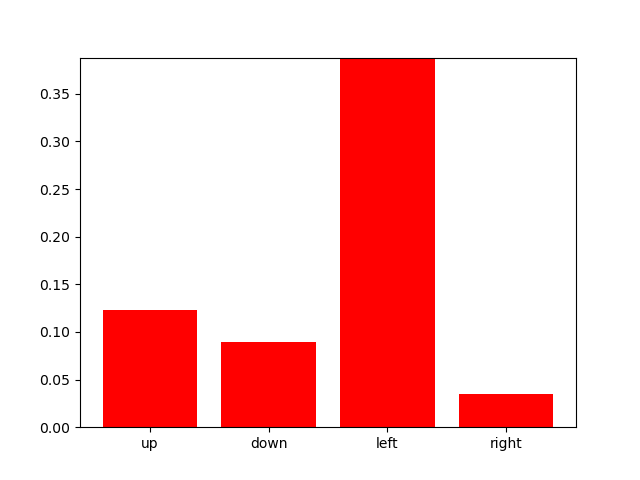

In [35]:
# loss function
def cross_entropy_loss(p, q):
    '''
    :params:
    p: np.array, categorical distribution
    q: np.array, categorical distribution
    '''
    return -np.mean(q*np.log(p) + (1-q)*np.log(1-p))



fig, ax = plt.subplots()
def init():
    bar_container = ax.bar(events, pd.rvs(size=1)[0], color='r')
    return bar_container.patches

def run_animation(patches):
    def update(frame):
        global pd, q
        p = pd.rvs(100)
        ce_losses = np.array([cross_entropy_loss(i, q) for i in p])
        perc = 30
        boundary = np.percentile(ce_losses, perc) #Only keep samples with CE loss <- 30th percentile
        while boundary < ce_losses.min(): # Check that we have at least on proposal on our elite group
            perc += 1
            boundary= np.percentile(ce_losses, perc)
        elite = p[np.argwhere(ce_losses<=boundary)].reshape(-1,4)
        pbest = np.nanmean(elite, axis=0)
        for prob, rect in zip(pbest, patches):
            rect.set_height(prob)
        pd = stats.dirichlet(alpha=pbest) #updates parameters of the Dirichlet
        return patches
    return update
    
patches = init()
ani = FuncAnimation(fig, run_animation(patches), frames=50, blit=True, repeat=False)